# CAP-4770: Final Project

## Overview

This project aims to develop an accurate (with a testing accuracy above 90%) Random Forest Classifier that can be used to determine whether a news story is real or fake. This classifier will be trained on a set of vectorized news story titles. To help boost its accuracy, several additional constructed features will be used: cluster purity and ID, Naive Bayes Classifier results, a simple word count, capital letter count, capital letter ratio, and a boolean for exclamatory marks.

<div class="alert alert-block alert-info">
<b>Note:</b> While the ultimate project goal is to construct the best possible classifier, the project's learning objectives are to explore applications of the following subjects discussed this semester in class: Principal Component Analysis, Count Vectorization, TF-IDF Vectorization, K-Means Clustering, Naive Bayes Classification, and Random Forest Classifiers. To that end, the project will focus on these subjects.
</div>

## 1. Import

First, we will import all needed libraries/classes and define any helper functions.

In [1]:
# Imports

# Standard library
import random
import sqlite3

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import sparse

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, silhouette_score, normalized_mutual_info_score, 
                             adjusted_rand_score)

In [2]:
# Helper Functions

def plot_pca_projection_3d(x_pca, y_labels, vec_name="Vectorizer"):
    """
    Plot 3D PCA projection of text data, color-coded by label.

    Parameters:
    - x_pca: 3D PCA-reduced feature matrix (shape: [n_samples, 3])
    - y_labels: list of labels ('0' or '1')
    - vec_name: string label for plot title
    """
    assert x_pca.shape[1] >= 3, "x_pca must have at least 3 components for 3D plot"

    colors = ["blue" if label == "0" else "red" for label in y_labels]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=colors, alpha=0.6)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Real News',
               markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Fake News',
               markerfacecolor='red', markersize=10)
    ]

    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title(f"3D PCA Projection ({vec_name})")
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()


def vectorize_and_reduce(x_titles, vectorizer, n_components=2):
    """
    Vectorize text and apply PCA reduction.

    Parameters:
    - x_titles: list of text strings
    - vectorizer: sklearn vectorizer (e.g., CountVectorizer or TfidfVectorizer)
    - n_components: number of PCA components to keep

    Returns:
    - pca: fitted PCA instance
    - x_pca: PCA-transformed array
    """
    x_vec = vectorizer.fit_transform(x_titles).toarray()
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x_vec)
    return pca, x_pca


def plot_pca_projection(x_pca, y_labels, vec_name="Vectorizer"):
    """
    Plot 2D PCA projection of text data, color-coded by label.

    Parameters:
    - x_pca: 2D PCA-reduced feature matrix
    - y_labels: list of labels ('0' or '1')
    - vec_name: string label for plot title
    """
    colors = ["blue" if label == "0" else "red" for label in y_labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=colors, alpha=0.6)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Real News',
               markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Fake News',
               markerfacecolor='red', markersize=10)
    ]

    plt.legend(handles=legend_elements, title="Legend")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"2D PCA Projection ({vec_name})")
    plt.grid(True)
    plt.show()


def display_pca_words(components, features, n=20, d=2):
    """
    Show top positive and negative contributing words for PC1, PC2, and PC3.

    Parameters:
    - components: PCA components matrix
    - features: list or array of feature names
    - n: number of top/bottom features to display
    """
    assert components.shape[0] >= 2, f"Need at least {d} PCA components."

    def top_words(pc):
        return features[pc.argsort()[:n]], features[pc.argsort()[::-1][:n]]

    pc1_neg, pc1_pos = top_words(components[0])
    pc2_neg, pc2_pos = top_words(components[1])

    df = pd.DataFrame({
        "PC1 Negative": pc1_neg,
        "PC1 Positive": pc1_pos,
        "PC2 Negative": pc2_neg,
        "PC2 Positive": pc2_pos
    })

    if d == 3:
        pc3_neg, pc3_pos = top_words(components[2])
        df['PC3 Negative'] = pc3_neg
        df['PC3 Positive'] = pc3_pos
    
    display(df)


def evaluate_clustering_model(pca_data, true_labels, k_range=range(2, 31)):
    """
    Evaluate KMeans clustering over a range of k using clustering quality metrics.

    Parameters:
    - pca_data: 2D PCA-transformed data
    - true_labels: list of ground-truth labels
    - k_range: iterable of k values
    """
    results = []

    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(pca_data)

        sil = silhouette_score(pca_data, labels)
        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)

        results.append({
            "K": k,
            "Silhouette": sil,
            "Inertia": model.inertia_,
            "ARI": ari,
            "NMI": nmi
        })

    df = pd.DataFrame(results)
    display(df)


def analyze_cluster_purity(pca, cluster_labels, sample_labels):
    """
    Visualize cluster structure and purity.

    Parameters:
    - pca: 2D PCA-reduced data
    - cluster_labels: predicted cluster assignments
    - sample_labels: true labels ('0' or '1')
    """
    cluster_labels = np.array(cluster_labels)
    sample_labels = np.array(sample_labels)
    num_clusters = len(np.unique(cluster_labels))
    cmap = plt.get_cmap("tab10", num_clusters)

    def get_fake_pct_per_cluster():
        return [
            np.mean(sample_labels[cluster_labels == i] == '1')
            for i in range(num_clusters)
        ]

    fake_pcts = get_fake_pct_per_cluster()
    overall_fake_pct = np.mean(sample_labels == '1')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # PCA Scatter
    ax = axes[0]
    for i in range(num_clusters):
        mask = cluster_labels == i
        ax.scatter(pca[mask, 0], pca[mask, 1], color=cmap(i), label=f"Cluster {i}", alpha=0.6)
    ax.set_title("KMeans Clustering")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

    # Bar Chart
    ax = axes[1]
    bars = ax.bar(range(num_clusters), fake_pcts, color=[cmap(i) for i in range(num_clusters)])
    ax.axhline(overall_fake_pct, color='red', linestyle='--', linewidth=2, label="Overall Fake %")
    ax.set_title("Cluster Purity (Fake News %)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Fake News Percentage")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(num_clusters))
    ax.set_xticklabels([f"C{i}" for i in range(num_clusters)])
    ax.legend()

    plt.tight_layout()
    plt.show()


def evaluate_cluster_predictivity(pca, cluster_labels, true_labels):
    """
    Assess cluster utility for classification and structure.

    Metrics:
    - Logistic regression accuracy
    - Adjusted Rand Index (ARI)
    - Normalized Mutual Information (NMI)
    - Silhouette Score

    Parameters:
    - pca: PCA-reduced data
    - cluster_labels: predicted cluster assignments
    - true_labels: true class labels ('0' or '1')
    """
    cluster_onehot = pd.get_dummies(cluster_labels, prefix="Cluster")

    clf = LogisticRegression(max_iter=1000)
    acc = cross_val_score(clf, cluster_onehot, true_labels, scoring='accuracy', cv=5).mean()
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    sil = silhouette_score(pca, cluster_labels)

    print("Cluster Predictiveness Evaluation:")
    print(f"  Accuracy (LogReg): {acc:.3f}")
    print(f"  Silhouette Score: {sil:.3f}")
    print(f"  ARI: {ari:.3f}")
    print(f"  NMI: {nmi:.3f}")


def compute_sparse_feature(titles, func):
    """
    Apply a scalar feature function to each title and return as a sparse column vector.

    Parameters:
    - titles: list of text strings (titles)
    - func: function that takes a single string (title) and returns a numeric value (e.g. word count)

    Returns:
    - csr_matrix (n_samples, 1): sparse matrix of computed feature values
    """
    values = np.array([float(func(title)) for title in titles], dtype=np.float64).reshape(-1, 1)
    return sparse.csr_matrix(values)


def plot_normalized_confusion_matrix(labels_test, y_pred):
    """
    Plot a normalized confusion matrix for binary classification (labels: '0' = true, '1' = fake).

    Parameters:
    - labels_test: list or array of true labels (as strings: '0' or '1')
    - y_pred: list or array of predicted labels (as strings: '0' or '1')
    """
    # Define custom labels
    custom_labels = ["true", "fake"]

    # Compute normalized confusion matrix
    cm_normalized = confusion_matrix(
        labels_test,
        y_pred,
        labels=["0", "1"],
        normalize='true'
    )

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                  display_labels=custom_labels)
    
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title("Normalized Confusion Matrix - Composite Random Forest Classifier")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()


def display_top_feature_importances(vectorizer, clf_RF, extra_features, top_n=20):
    """
    Display top N feature importances from a Random Forest classifier, combining TF-IDF and extra features.

    Parameters:
    - vectorizer: a fitted vectorizer with get_feature_names_out() method (e.g., TfidfVectorizer)
    - clf_RF: a trained RandomForestClassifier with feature_importances_ attribute
    - extra_features: a dict or ordered mapping of manually added feature names (e.g., {"NB_Prob": ..., "SomeOtherFeature": ...})
    - top_n: number of top features to display (default: 20)
    """

    # Combine TF-IDF and extra feature names
    feature_names = vectorizer.get_feature_names_out()
    extra_feature_names = ["NB_Prob"] + list(extra_features.keys())
    combined_feature_names = list(feature_names) + extra_feature_names

    # Extract feature importances
    importances = clf_RF.feature_importances_

    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        "Feature": combined_feature_names,
        "Importance": importances
    })

    # Round and tag types
    feature_importance_df["Importance"] = feature_importance_df["Importance"].round(6)
    feature_importance_df["Type"] = [
        "Extra" if f in extra_feature_names else "TF-IDF"
        for f in feature_importance_df["Feature"]
    ]

    # Get top N
    top_features_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(top_n)

    # Display
    print("Top Feature Importances (Random Forest)\n")
    print(top_features_df.to_string(index=False))

## 2. Pre-Processing

Second, we will generate the data frame (df) from the project's database, ensuring that all NULL entries are excluded, and verify that the df is constructed as expected.

In [3]:
# Build DF from DB, Remove NULL entries

conn = sqlite3.connect("../WELFake_Dataset.db")
df = pd.read_sql(
    "SELECT id, title, label FROM WELFake_Dataset WHERE title IS NOT NULL", 
    conn,  
    index_col="id"
)

In [4]:
# Check DF

df.info(verbose=True)
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 71576 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   label   71576 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


,title,label
id,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1


## 3. Exploratory Data Analysis

To reduce computational loads, the data analysis will be conducted using a random sample drawn from the dataset. This will enable us to complete computationally intensive tasks, such as Principal Component Analysis, within the limitations of a personal computer.

The dataset contains approximately 70,000 tuples. Through trial and error, it was determined that 10,000 was the upper end of my personal machine's capability.

In [5]:
# Get Sample

sample = df.sample(n=10000, random_state=42)
titles_sample = sample['title'].tolist()
labels_sample = sample['label'].tolist()

sample.head(5)

,title,label
id,,
58768,New York mayor criticized for proposed limits ...,0
14559,FIRE THIS GUY! MUSLIM CNN HOST TWEETS Out Vile...,1
52795,CNN HOST And Crybaby Hillary Surrogate Get BRU...,1
53802,Senate panel to hear from U.S. antitrust bosses,0
453,U.N. freedom of speech expert concerned about ...,0


Now that the sample is collected, we can examine a selection of titles and verify whether the features we have constructed are relevant. That selection (seen above) validates our use of the features: capital count, capital ratio, and Boolean exclamatory mark.

Seeing this, we will now use the sample titles and labels to help determine what vectorization method should be used. 

<div class="alert alert-block alert-info">
<b>Note:</b> We will remain in a two- and three-dimensional space; the reason for this is twofold: it benefits visualization and, through testing, yields similar predictive results as four- and eight-dimensional spaces.
</div>

### Visualize Data with Count Vectorizing, PCA, and K-Means

The first visualization will be conducted with a simple count vectorizer and visualized with a 2D/3D PCA plot.

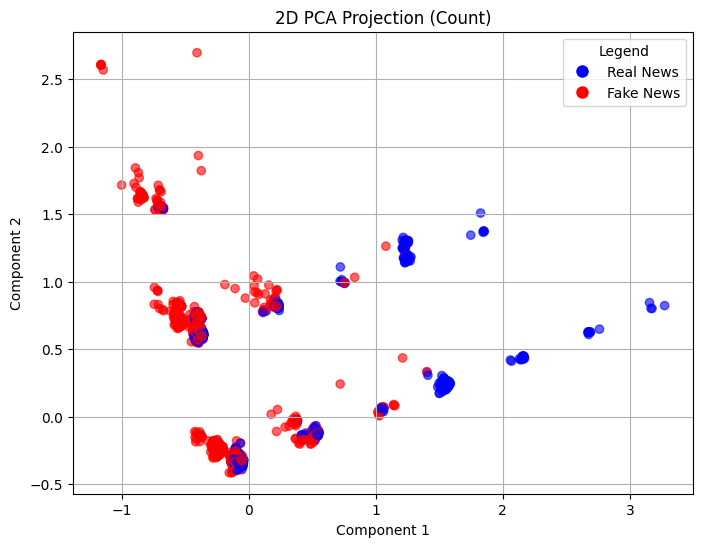

In [6]:
# Visualize Data (Count Vectorizer) and 2D PCA Plot

vectorizer = CountVectorizer(stop_words='english', min_df=2)

pca, x_pca = vectorize_and_reduce(titles_sample, vectorizer, 2)
plot_pca_projection(x_pca, labels_sample, vec_name="Count")

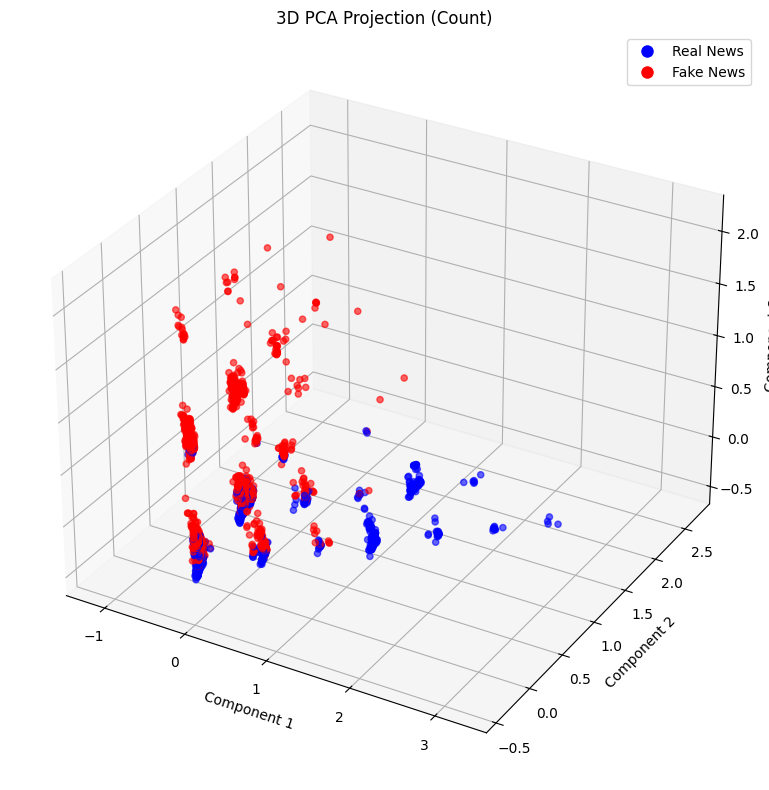

In [7]:
# Visualize Data (Count Vectorizer) and 3D PCA Plot

pca = PCA(n_components=3)
x_pca_3d = pca.fit_transform(vectorizer.fit_transform(titles_sample).toarray())

plot_pca_projection_3d(x_pca_3d, labels_sample, vec_name="Count")

In [8]:
# Words Driving PC1, PC2, and PC3

components = pca.components_
features = vectorizer.get_feature_names_out()

display_pca_words(components, features, 10, 3)

,PC1 Negative,PC1 Positive,PC2 Negative,PC2 Positive,PC3 Negative,PC3 Positive
0,trump,new,hillary,trump,trump,video
1,video,york,obama,new,says,hillary
2,watch,times,state,york,breitbart,obama
3,just,briefing,eu,times,house,new
4,president,today,says,donald,russia,times
5,hillary,review,election,video,korea,watch
6,obama,california,police,president,north,york
7,says,evening,clinton,watch,china,black
8,breitbart,dies,2016,supporters,eu,clinton
9,white,say,fbi,just,deal,president


These visualizations show that the data forms distinct clusters. These clusters may help distinguish between real and fake news. However, some of the most significant clusters contain a mix of both real and fake articles. To determine whether cluster membership can be a useful predictive feature, we will evaluate:

> 1. Cluster structure and separation using the Silhouette Score and Inertia,
> 2. Alignment between clusters and true labels using the Adjusted Rand Index (ARI), and
> 3. The mutual information shared between cluster assignments and true labels using Normalized Mutual Information (NMI).

Counting by hand, there are around 19 to 20 well-defined clusters. With this in mind, we will look at the above metrics for a cluster number between 15 and 24.

In [9]:
# Find Optimal Number of Clusters

evaluate_clustering_model(x_pca, labels_sample, range(15, 24))

,K,Silhouette,Inertia,ARI,NMI
0,15,0.834518,14.995697,0.024769,0.122272
1,16,0.830895,12.618633,0.024657,0.121040
2,17,0.617854,11.529285,0.024260,0.106924
3,18,0.617047,11.110397,0.024255,0.106901
4,19,0.617414,10.277246,0.024254,0.106865
5,20,0.616251,9.835577,0.024064,0.106455
6,21,0.606161,8.345463,0.023303,0.105451
7,22,0.604997,7.903793,0.023113,0.105054
8,23,0.634941,7.116955,0.024819,0.100151


The results of this evaluation suggest that there is a notable increase in the Silhouette and NMI at 16 clusters, accompanied by minimal changes in Inertia and ARI. Selecting 16 will bring us as close to our visually identified number of clusters while yielding the best Silhouette and NMI scores from our tested group.

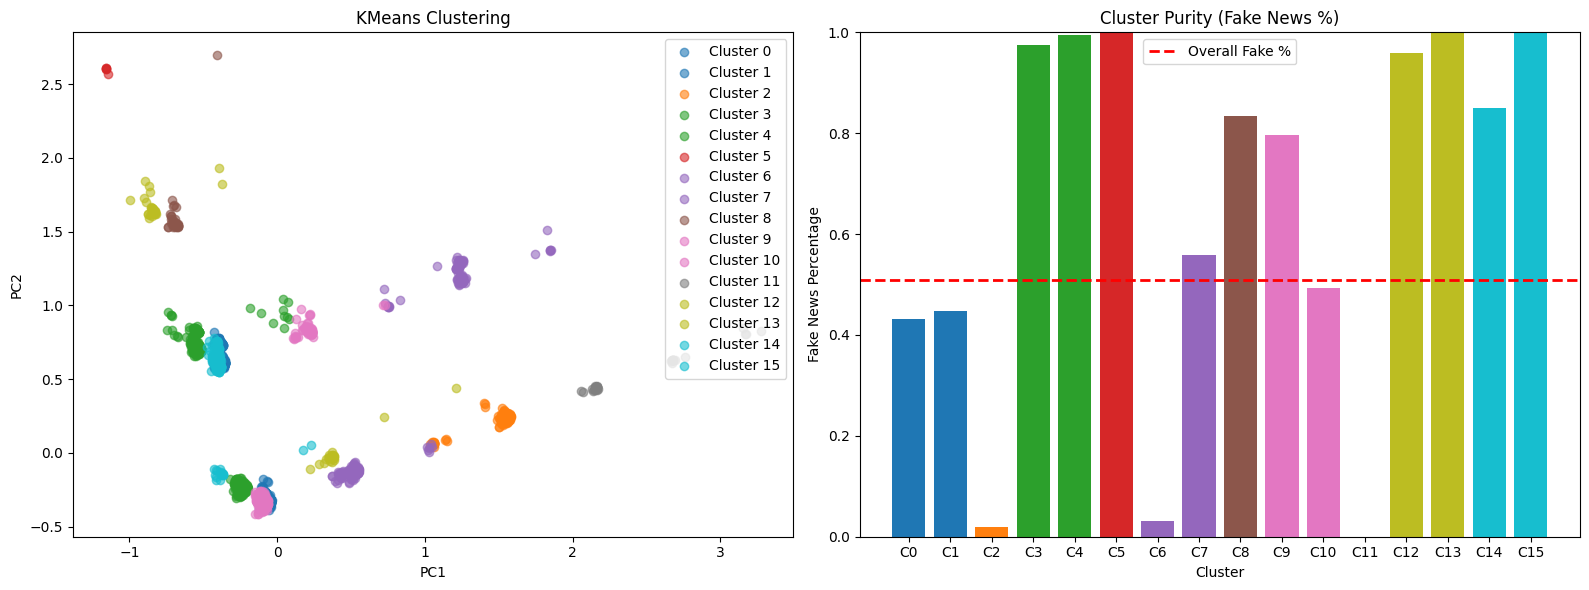

In [10]:
# Perform Cluster Analysis with KMeans

kmeans = KMeans(n_clusters=16, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(x_pca_3d)
analyze_cluster_purity(x_pca_3d, cluster_labels_kmeans, labels_sample)

Having created our clusters, we will now evaluate them against Silhouette, ARI, NMI, and also incorporate a Logistic Regression Model, using the cluster ID as the predictor, to check their predictive capability (Accuracy).

In [11]:
# Determine Cluster Quality

evaluate_cluster_predictivity(x_pca_3d, cluster_labels_kmeans, labels_sample)

Cluster Predictiveness Evaluation:
  Accuracy (LogReg): 0.678
  Silhouette Score: 0.720
  ARI: 0.037
  NMI: 0.129


### Visualize Data with TF-IDF Vectorizing, PCA, and K-Means

The second visualization will be conducted with a Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer and 2D/3D PCA plot. The methodology will be the same, so comments will be omitted until the end.

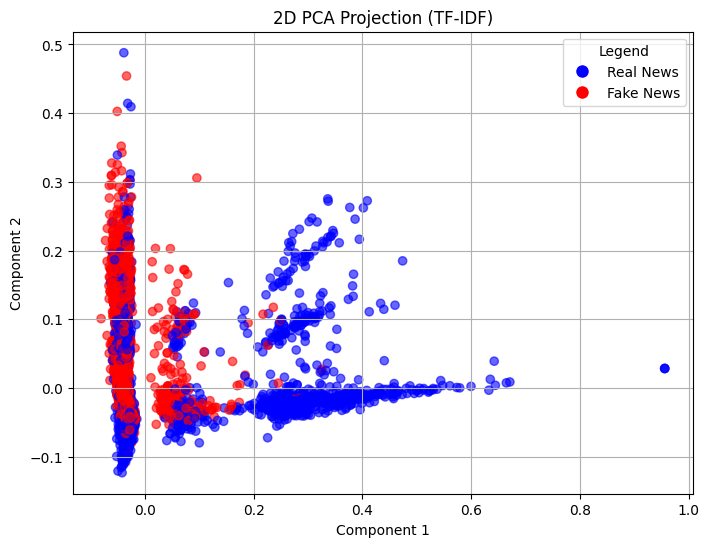

In [12]:
# Visualize Data (TF-IDF Vectorizer) and 2D PCA Plot

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)

pca, x_pca = vectorize_and_reduce(titles_sample, tfidf_vectorizer, 2)
plot_pca_projection(x_pca, labels_sample, vec_name="TF-IDF")

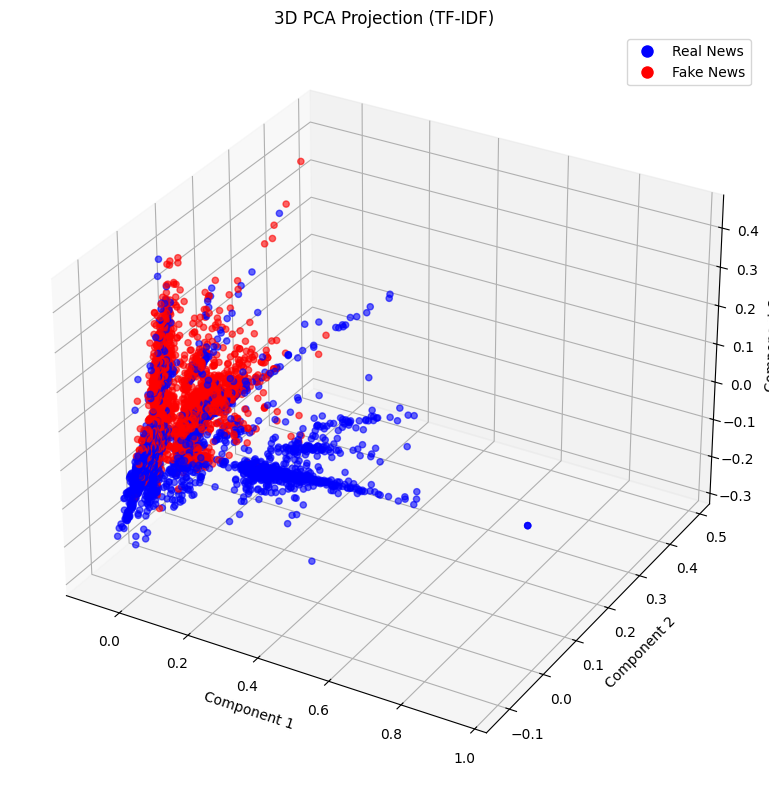

In [13]:
# Visualize Data (TF-IDF Vectorizer) and 3D PCA Plot

pca = PCA(n_components=3)
x_pca_3d = pca.fit_transform(tfidf_vectorizer.fit_transform(titles_sample).toarray())

plot_pca_projection_3d(x_pca_3d, labels_sample, vec_name="TF-IDF")

In [14]:
# Find Optimal Number of Clusters

evaluate_clustering_model(x_pca_3d, labels_sample, range(4, 16))

,K,Silhouette,Inertia,ARI,NMI
0,4,0.612695,39.873583,0.023729,0.085624
1,5,0.537585,35.808830,0.037387,0.100479
2,6,0.525827,32.694954,0.033028,0.098663
3,7,0.525373,30.423518,0.034466,0.098458
4,8,0.493295,28.842543,0.038335,0.113186
5,9,0.501503,25.179593,0.035850,0.110648
6,10,0.500560,22.068185,0.031582,0.109076
7,11,0.513831,20.330329,0.030998,0.108662
8,12,0.518196,17.108713,0.027857,0.107348
9,13,0.521037,15.797480,0.027473,0.106747


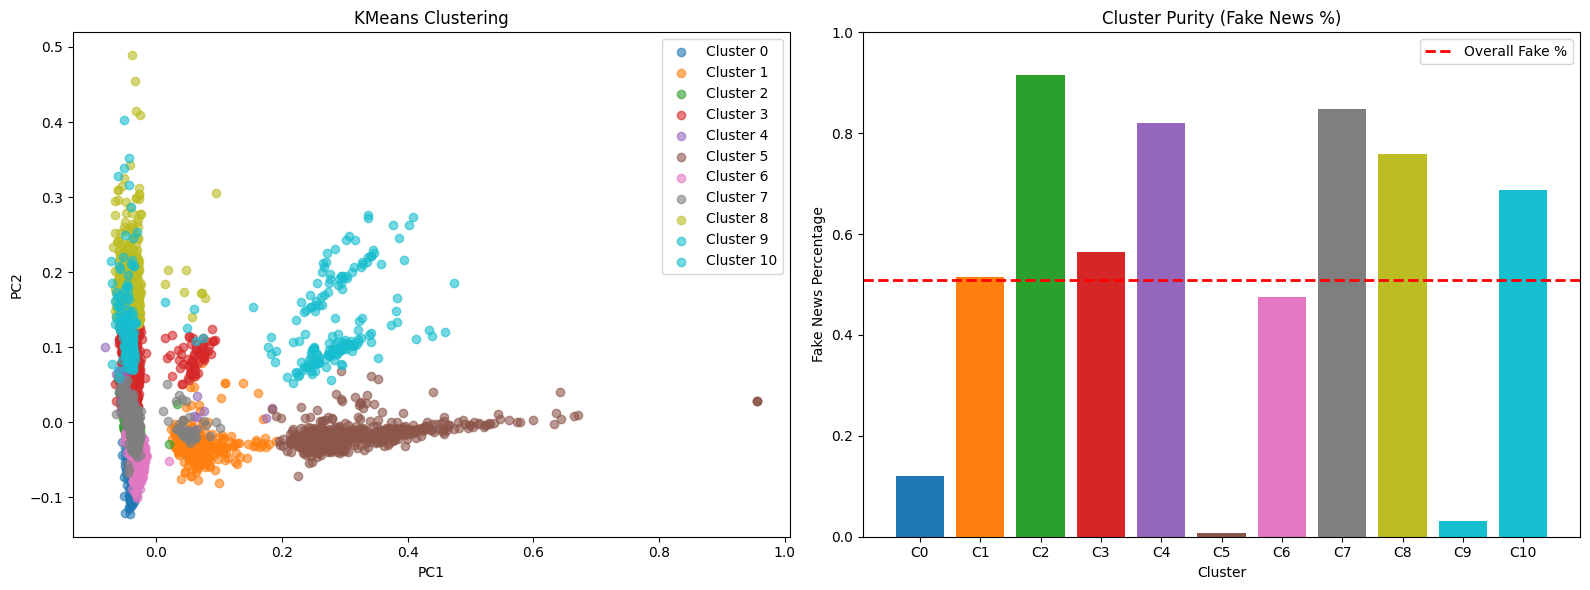

In [15]:
# Perform Cluster Analysis with KMeans

kmeans = KMeans(n_clusters=11, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(x_pca_3d)
analyze_cluster_purity(x_pca_3d, cluster_labels_kmeans, labels_sample)

In [16]:
# Determine Cluster Quality

evaluate_cluster_predictivity(x_pca_3d, cluster_labels_kmeans, labels_sample)

Cluster Predictiveness Evaluation:
  Accuracy (LogReg): 0.661
  Silhouette Score: 0.514
  ARI: 0.031
  NMI: 0.109


Immediately upon viewing the 2D and 3D PCA plots, the TF-IDF method appears to produce less valuable results. Continuing with the same methodology as before, we observe that the final accuracy with this method is roughly 66% (although this value changes slightly from run to run). As a reminder, the previous cluster's accuracy was approximately 68%. 

Both attempts to cluster our titles and use those clusters as a predictive measure of the label have seen less than stellar results. The first attempt created distinct clusters that were heavily mixed; the second attempt did not even form distinct clusters, and both had relatively poor predictive results.

With this, we will select the simple count vectorizer method moving forward and will strike our use of cluster purity and ID as classifier features.

### Determine Best Params for Random Forest and Naive Bayes Classifier(s)

The last thing we will do in this section is to test a variety of parameters in the construction of our Naive Bayes and Random Forest models. To save on CPU cycles, we will utilize the Randomized Search function to test a range of parameters and return the best-performing combination. From this, we can get a baseline for both models to use moving forward.

In [17]:
# Determine NB Best Params

# Parameter Grid
param_dist = {
    'alpha': np.logspace(-3, 1, 20),
    'fit_prior': [True, False]
}

# Set up randomized search
random_search_nb = RandomizedSearchCV(
    estimator=MultinomialNB(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    random_state=42,
    verbose=0
)

# Vectorize titles
vec = vectorizer.fit_transform(titles_sample)

# Convert labels to int
labels_int = np.array(labels_sample).astype(int)

# Run search
random_search_nb.fit(vec, labels_int)

# Results
print("Best Parameters:", random_search_nb.best_params_)
print("Best F1 Score:", random_search_nb.best_score_)

Best Parameters: {'fit_prior': True, 'alpha': np.float64(3.792690190732246)}
Best F1 Score: 0.8542162791148434


In [18]:
# Determine RF Best Params

# Parameter Grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'max_features': ['sqrt', 0.2, 0.5],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=0,
    random_state=42
)

# Vectorize titles
vec = vectorizer.fit_transform(titles_sample)

# Convert labels to int
labels_int = np.array(labels_sample).astype(int)

# Run random search
random_search.fit(vec, labels_int)

# Show Best Parameters
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Best F1 Score: 0.8505299339552139


Both Best Parameter's models return roughly similar, roughly good F1 scores. Demonstrating a good balance between recall and precision. We will then use the Best Parameters result from each in our next section...

## 4. Modeling

Modeling will consist of four phases:

> 1. Data Prep
> 2. Building Features
> 3. Model Training
> 4. Model Testing

### Data Prep

When considering what our train-test split should be, we encountered several suggestions. The most popular were 80/20 and 70/30. However, we decided to match our train-test split with that of Lab 2, which is 1/7 or 0.14 (the minst data set, consisting of 70,000 entries, with 10,000 used for testing).

In [19]:
# Split DF

titles = df['title']
labels = df['label']
titles_train, titles_test, labels_train, labels_test = train_test_split(
    titles,
    labels,
    test_size=0.14,
    stratify=labels,
    random_state=42
)

In [20]:
# Vectorize

vectorizer = CountVectorizer(stop_words='english', min_df=2)

x_train = vectorizer.fit_transform(titles_train)
x_test = vectorizer.transform(titles_test)

### Building Feature(s)
#### Naive Bays

In [21]:
# Fit and Check NB Classifier (built with Best Parameters)

best_nb_params = {
    'fit_prior': True, 
    'alpha': 3.792690190732246,
}

# Fit
clf_NB = MultinomialNB()
clf_NB.fit(x_train, labels_train)

# Check
NB_pred = clf_NB.predict(x_test)
print(classification_report(labels_test, NB_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4904
           1       0.88      0.89      0.89      5117

    accuracy                           0.88     10021
   macro avg       0.88      0.88      0.88     10021
weighted avg       0.88      0.88      0.88     10021



In [22]:
# Create NB Feature (nb_probs_train)

# Training Set
nb_probs_train = clf_NB.predict_proba(x_train)[:, 1].reshape(-1, 1)

# Test Set
nb_probs_test = clf_NB.predict_proba(x_test)[:, 1].reshape(-1, 1)

#### Word Count

The following features are constructed via functions. Those functions will be used later as a parameter for feature extraction from the dataset. This was to avoid holding multiple large arrays in memory independently.

In [23]:
def word_count(title):
    return len(title.split()) if title else 0

#### Capital Letter Count and Ratio

In [24]:
def cap_count(title):
    return sum(1 for c in title if c.isupper()) if title else 0
def capital_ratio(title):
    caps = sum(1 for c in title if c.isupper())
    non_caps = sum(1 for c in title if c.islower())
    return float(caps) / non_caps if non_caps > 0 else 0.0

#### Has Exclamation Mark

In [25]:
def has_exclamation(title):
    return int('!' in title) if title else 0

### Model Training

Now that the features are constructed, we will first build and train a Random Forest Classifier using only the vectorized titles to establish a baseline for evaluating the effectiveness of those constructed features.

#### Baseline Random Forest

The baseline Random Forest Classifier will be used for comparison with our final product and its added features. After construction, we will assess its accuracy, confusion matrix, and the degree of agreement overlap between it and the aforementioned Naive Bayes model.

In [26]:
# Fit and Check RF Classifier (built with Best Parameters)

best_rf_params = {
    'n_estimators': 100,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': None,
    'class_weight': 'balanced',
}

# Fit
clf_RF = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
clf_RF.fit(x_train, labels_train)

# Check
RF_pred = clf_RF.predict(x_test)
print(classification_report(labels_test, RF_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4904
           1       0.88      0.89      0.88      5117

    accuracy                           0.88     10021
   macro avg       0.88      0.88      0.88     10021
weighted avg       0.88      0.88      0.88     10021



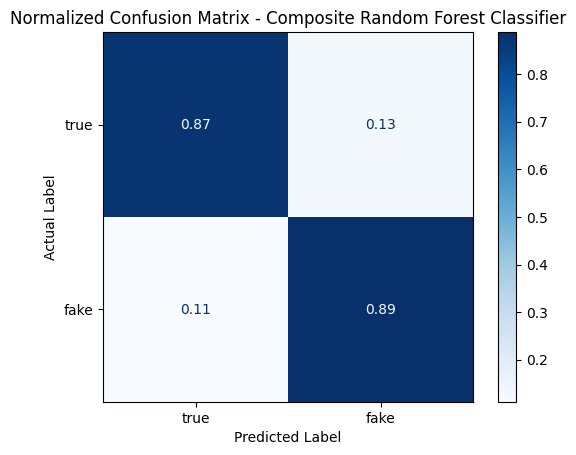

In [28]:
# Confusion Mx

plot_normalized_confusion_matrix(labels_test, RF_pred)

In [29]:
# Overlap between NB and RF

le = LabelEncoder()
rf_encode = le.fit_transform(RF_pred)
nb_encode = le.transform(NB_pred)
agreement = np.mean(rf_encode == nb_encode)
print(f"Agreement Rate: {agreement:.4f}")

Agreement Rate: 0.9001


### Random Forest With Added Features

In [30]:
# Combind Features

extra_features = {
    "WordCount": word_count,
    "CapCount": cap_count,
    "CapRatio": capital_ratio,
    "HasExclamation": has_exclamation,
}

def extract_features(titles, feature_funcs):
    return [compute_sparse_feature(titles, func) for func in feature_funcs.values()]

extra_train = extract_features(titles_train, extra_features)
extra_test = extract_features(titles_test, extra_features)

x_train_combined = sparse.hstack([x_train, nb_probs_train] + extra_train).tocsr()
x_test_combined = sparse.hstack([x_test, nb_probs_test] + extra_test).tocsr()

In [31]:
# Fit and Check RF Composit Classifier

clf_RF.fit(x_train_combined, labels_train)

# Predict on test set
y_pred = clf_RF.predict(x_test_combined)

# Evaluate
print(classification_report(labels_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.938     0.924     0.931      4904
           1      0.928     0.942     0.935      5117

    accuracy                          0.933     10021
   macro avg      0.933     0.933     0.933     10021
weighted avg      0.933     0.933     0.933     10021



Initially, it appears that our constructed features are beneficial to our classifier. They move the accuracy from 88% to 93% and above our target threshold. We will evaluate this model further in the conclusion.

## 5. Conclusions

The evaluation of our Random Forest Classifier will be two-fold. The first part will involve calculating the confusion matrix and evaluating the model's ability to predict both true positives and negatives accurately. The second will be an evaluation of the most important features for that model.

While we have achieved our goal of over 90% accuracy, upon closer examination of the confusion matrix, we observe that the classifier is actually better at identifying fake stories. This can be compared against our baseline model's confusion matrix (87% and 89%) to confirm that this split existed before the addition of our constructed features.

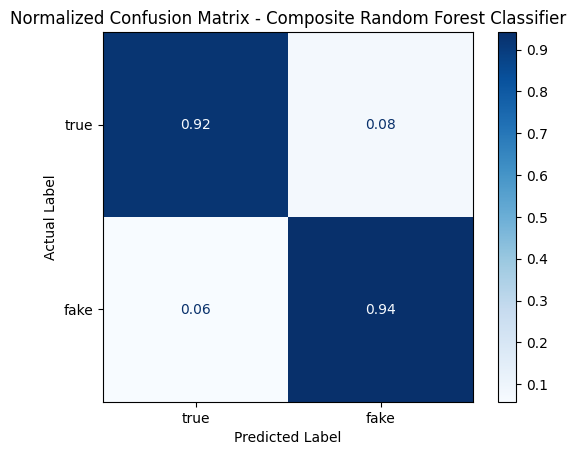

In [32]:
# Check Normalized Confusion Matrix

plot_normalized_confusion_matrix(labels_test, y_pred)

Knowing that our added features were helpful overall in classification, we can then assess their effectiveness. This approach yields some expected and a few surprising (to us) results.

> 1. None of the added features exceeds a 50% importance.
> 2. Naive Bayes is the most important added feature.
> 3. The Boolean for HasExclamation is less important than some individual words, but more important than most.

In [33]:
# Display TF-IDF and Extra Features by Importance

display_top_feature_importances(vectorizer, clf_RF, extra_features, top_n=15)

Top Feature Importances (Random Forest)

       Feature  Importance   Type
       NB_Prob    0.250706  Extra
      CapRatio    0.137616  Extra
      CapCount    0.125668  Extra
     WordCount    0.040458  Extra
         times    0.032909 TF-IDF
          york    0.031255 TF-IDF
         video    0.031088 TF-IDF
     breitbart    0.023667 TF-IDF
           new    0.020897 TF-IDF
HasExclamation    0.016675  Extra
       hillary    0.012441 TF-IDF
          says    0.007505 TF-IDF
          just    0.007041 TF-IDF
         watch    0.006103 TF-IDF
      breaking    0.003983 TF-IDF


The first two points are not surprising. It would be unlikely that quantifying the use of capital letters (CapRatio, CapCount) or word counts (WordCount) would exceed the importance of looking at every word in the title (NB_Prob). It is also not surprising that Naive Bayes is as low as it is. The overlap between the Baseline Random Forest and the Naive Bayes was 90%, which was higher than the accuracy of both models, indicating that they are in agreement more often than they are correct.

What is interesting is how high the existence of an exclamation mark is in predicting the 'fakeness' of a news story title. The only individual words that eclipse it are ones that reference the title's source (new, york, times, breitbart) and news format (video).